# Modelo de Kermack McKendrick

hola

In [4]:
include("Taylor.jl")
using ADT

Las ecuaciones diferenciales que rigen el modelo para una especie son:

$$ \frac{dS}{dt} = -\beta SI$$
$$ \frac{dI}{dt} = \beta SI - \gamma I $$
$$ \frac{dR}{dt} = \gamma I $$
donde $S$ es el número de individuos suceptibles, $I$ el de individuos infectados y $R$ el de recuperados; así como $\beta$ es la tasa de transmisión de la infección y $\gamma$ la tasa de recuperación de la especie.

En este modelo NO tomamos en cuenta los nacimientos y muertes, así que para una población fija se tiene que $ N = S(t) + I(t) + R(t)$ en todo tiempo.

In [93]:
function coefs_1(gamma, beta, S0, I0, R0, n = 40)
    s = [S0]
    i = [I0]
    r = [R0]
    
    
    F1(S,I) = beta*S*I
    F2(I) = gamma*I
    
    for k = 1:n
       
        
        Ts = Taylor(s)
        Ti = Taylor(i)
        Tr = Taylor(r)
        
        fs = -F1(Ts,Ti) # F1 = -b*S*I
        fi = F1(Ts, Ti) - F2(Ti)
        fr = F2(Ti) # F2 = g*I

        S0 = fs.pol[k]/k
        I0 = fi.pol[k]/k
        R0 = fr.pol[k]/k
        
        push!(s,S0)
        push!(r,R0)
        push!(i,I0)
    end
    s = Taylor(s)
    i = Taylor(i)
    r = Taylor(r)
    return s,i,r
        
end

coefs_1 (generic function with 3 methods)

Error absoluto

In [7]:
eps_abs = 1e-20

1.0e-20

In [37]:
function paso(a::Taylor, p = 40)
    
    while p != 0 && a.pol[p] == 0
       p = p-1;
    end
    
    h = 0.5*(eps_abs/abs(a.pol[p]))^(1/p)
end

paso (generic function with 2 methods)

In [10]:
function ev_horner{T<:Number}(a::Taylor,t0::T)
    
    n = gradomax(a)
    x1 = a.pol[n]
    
    for k = 1:n-1
        x1 = a.pol[n-k] + x1*t0
    end
    return x1
end

ev_horner (generic function with 1 method)

In [91]:
function integrador_kermack(N, I0, R0, t0, tf, gamma, beta)
    S0 = N - I0 - R0
    
    t = [t0]
    s = [S0]
    i = [I0]
    r = [R0]
    
    while t0 < tf
        
        S,I,R = coefs_1(gamma, beta, S0, I0, R0)
        
        h_s = paso(S)
        h_i = paso(I)
        h_r = paso(R)
        h = min(h_s, h_i, h_r)
        
        t0 += h
        
        S0 = ev_horner(S,h)
        I0 = ev_horner(I,h)
        R0 = ev_horner(R,h)
        
        push!(t,t0)
        push!(s,S0)
        push!(i,I0)
        push!(r,R0)
    end
    return t,s,i,r
end

integrador_kermack (generic function with 2 methods)

In [94]:
N = 1.
infectados_iniciales = N/1000
recuperados_iniciales = 0.0
t_inicial = 0.
t_final = 160.
beta = 0.2
gamma = 0.1

@time t,s,i,r = integrador_kermack(N, infectados_iniciales, recuperados_iniciales, t_inicial, t_final, gamma, beta);

  0.243297 seconds (7.83 M allocations: 126.415 MB, 4.20% gc time)


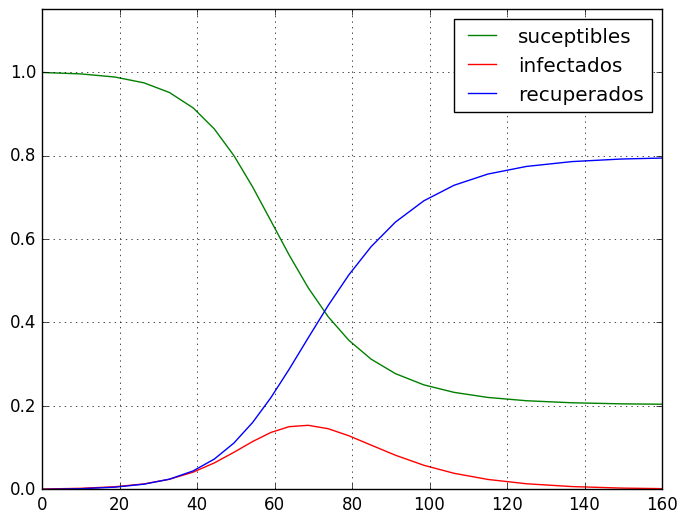

In [98]:
using PyPlot

plot(t,s, color = "green", label = "suceptibles")
plot(t,i, color = "red", label = "infectados")
plot(t,r, color = "blue", label = "recuperados")
axis([0,160,0,1.15])
grid()
legend()
show()

Para un sistema de $K$ especies, el modelo se vuelve

$$ \frac{dS_i}{dt} = -\sum_{j = 1}^K \beta_{ij} S_iI_j$$
$$ \frac{dI_i}{dt} = \sum_{j = 1}^K\beta_{ij} S_iI_j - \gamma_i I_i $$
$$ \frac{dR_i}{dt} = \gamma_i I_i $$
donde $S$ es el número de individuos suceptibles, $I$ el de individuos infectados y $R$ el de recuperados; así como $\beta$ es la tasa de transmisión de la infección y $\gamma$ la tasa de recuperación de la especie.


$$ \frac{dS_i}{dt} = -\beta_{i1} S_iI_1 - \beta_{i2} S_iI_2 - \beta_{i3} S_iI_3$$
$$ \frac{dI_i}{dt} = \beta_{i1} S_iI_1 + \beta_{i2} S_iI_2 + \beta_{i3} S_iI_3 - \gamma_i I_i $$
$$ \frac{dR_i}{dt} = \gamma_i I_i $$

In [20]:
function coefs_3(gamma, beta, S0_1, S0_2, S0_3, I0_1, I0_2, I0_3, R0 = 0.0, n = 20)
    S = Array{Array{Float64,1},1}();
    push!(S,[S0_1])
    push!(S,[S0_2])
    push!(S,[S0_3])
    I = Array{Array{Float64,1},1}();
    push!(I,[I0_1])
    push!(I,[I0_2])
    push!(I,[I0_3])

        
    F1(beta_ij,S,I) = -beta_ij*S*I
    F2(gamma_i,I) = gamma_i*I
    
    for k = 1:n-1
        Ts = [Taylor(S[j]) for j in 1:3]
        Ti = [Taylor(I[j]) for j in 1:3]
        
        for i = 1:3
            fs = 0
            fi = 0
            
            for j = 1:3
                fs += F1(beta[i,j],Ts[i],Ti[j])
            end
            
            fi = -fs - F2(gamma[i],Ti[i])
        
            S0 = fs.pol[k]/k
            I0 = fi.pol[k]/k

            push!(S[i], S0)
            push!(I[i], I0)
        end
    end
    s = [Taylor(S[i]) for i in 1:3]
    i = [Taylor(I[i]) for i in 1:3]
    
    return s,i
end

coefs_3 (generic function with 3 methods)

In [21]:
beta = rand(3,3)/3
gamma = rand(3)/8

3-element Array{Float64,1}:
 0.0758233
 0.0964587
 0.0495617

In [22]:
S0_1 = 99.
S0_2 = 90.
S0_3 = 93.
I0_1 = 1.
I0_2 = 3.
I0_3 = 2.

@time coefs_3(gamma, beta, S0_1, S0_2, S0_3, I0_1, I0_2, I0_3);

  0.443010 seconds (618.56 k allocations: 26.295 MB, 2.19% gc time)


In [23]:
function kermack_3(N1, N2, N3, I0_1, I0_2, I0_3, t0, tf, gamma, beta)
    S0_1 = N1 - I0_1
    S0_2 = N2 - I0_2
    S0_3 = N3 - I0_3
        
    
    t = [t0]
    s = Array{Array{Float64,1},1}();
    push!(s,[S0_1])
    push!(s,[S0_2])
    push!(s,[S0_3])
    i = Array{Array{Float64,1},1}();
    push!(i,[I0_1])
    push!(i,[I0_2])
    push!(i,[I0_3])
    
    while t0 < tf
        S0_1 = s[1][end]
        S0_2 = s[2][end]
        S0_3 = s[2][end]
        I0_1 = i[1][end]
        I0_2 = i[2][end]
        I0_3 = i[3][end]
        
        S,I = coefs_3(gamma, beta, S0_1, S0_2, S0_3, I0_1, I0_2, I0_3)
        for k in 1:3
            h_s = paso(S[k])
            h_i = paso(I[k])
            h = min(h_s, h_i)
        
            t0 += h
        
            S0 = ev_horner(S[k],h)
            I0 = ev_horner(I[k],h)
        
            push!(t,t0)
            push!(s[k],S0)
            push!(i[k],I0)
        end
        
    end
    return t,s,i
end

kermack_3 (generic function with 1 method)

In [24]:
S,I = coefs_3(gamma, beta, S0_1, S0_2, S0_3, I1, I2, I3);

LoadError: LoadError: UndefVarError: I1 not defined
while loading In[24], in expression starting on line 1

In [25]:
h_s = paso(S[1])
h_i = paso(I[1])
h = min(h_s, h_i)
s0 = ev_horner(S[1], h)

LoadError: LoadError: MethodError: `getindex` has no method matching getindex(::ADT.Taylor{Float64}, ::Int64)
while loading In[25], in expression starting on line 1

In [26]:
t0 = 1.
while t0 < 1.5
    S,I = coefs_3(gamma, beta, S0_1, S0_2, S0_3, I0_1, I0_2, I0_3)
    for k in 1:3
        h_s = paso(S[k])
        h_i = paso(I[k])
        h = min(h_s, h_i)
        
        t0 += h
        S0 = ev_horner(S[k],h)
        I0 = ev_horner(I[k],h)
        
        push!(t,t0)
        push!(s[k],S0)
        push!(i[k],I0)
        end
        
    end

LoadError: LoadError: MethodError: `push!` has no method matching push!(::Float64, ::Float64)
Closest candidates are:
  push!(::Any, ::Any, !Matched::Any)
  push!(::Any, ::Any, !Matched::Any, !Matched::Any...)
  push!(!Matched::Array{Any,1}, ::ANY)
  ...
while loading In[26], in expression starting on line 2

In [27]:
t

75-element Array{Float64,1}:
   0.0    
   2.91704
   5.78553
   8.75666
  11.4292 
  13.9165 
  16.2899 
  18.591  
  20.8718 
  23.2177 
  25.3173 
  27.307  
  29.2406 
   ⋮      
 124.237  
 127.531  
 131.038  
 134.8    
 138.704  
 142.633  
 146.647  
 150.783  
 155.067  
 159.521  
 164.17   
   1.00438

In [28]:
s = Array{Array{Float64,1},1}();
    push!(s,[S0_1])
    push!(s,[S0_2])
    push!(s,[S0_3])
i = Array{Array{Float64,1},1}();
    push!(i,[I0_1])
    push!(i,[I0_2])
    push!(i,[I0_3])

3-element Array{Array{Float64,1},1}:
 [1.0]
 [3.0]
 [2.0]

In [29]:
S,I = coefs_3(gamma, beta, S0_1, S0_2, S0_3, I0_1, I0_2, I0_3);

In [30]:
S[1].pol

20-element Array{Float64,1}:
     99.0       
   -164.845     
  -4444.07      
 -67706.6       
     -6.28279e5 
     -2.0333e6  
      4.50849e7 
      9.97353e8 
      1.09029e10
      5.80695e10
     -3.62102e11
     -1.28927e13
     -1.67527e14
     -1.20036e15
      3.15549e14
      1.47395e17
      2.36358e18
      2.10771e19
      6.44181e19
     -1.43122e21

In [31]:
push!(i[1], i0)

LoadError: LoadError: UndefVarError: i0 not defined
while loading In[31], in expression starting on line 1

In [32]:
push!(s[1], s0)

LoadError: LoadError: UndefVarError: s0 not defined
while loading In[32], in expression starting on line 1

In [33]:
N1 = 0.5
N2 = 0.3
N3 = 0.2
I1 = N1/100
I2 = N2/100
I3 = N3/100
t_3,s_3,i_3 = kermack_3(N1, N2, N3, I1, I2, I3, 0., 10., gamma, beta)

([0.0,2.220440281269003,4.520552081043052,6.8426175874074335,8.814800726592248,11.02077417101408,13.359009450602034],[[0.495,0.4920625614076546,0.48879765716974627],[0.297,0.29584422998979953,0.2944488538121528],[0.198,0.2960799057806486,0.2946984227911544]],[[0.005,0.0069376394044649665,0.00901429420598704],[0.003,0.003444173659624447,0.004045941878788104],[0.002,0.00265346444142257,0.0034473087055848007]])

In [34]:
using PyPlot
t

LoadError: LoadError: ArgumentError: PyPlot not found in path
while loading In[34], in expression starting on line 1